## Klasifikasi Alzheimer Empat Kelas Menggunakan Model DenseNet169, ResNet50, dan VGG16
---
**Pandega Abyan Zumarsyah - Universitas Gadjah Mada**

Data yang digunakan di sini adalah data MRI untuk **Alzheimer 4 kelas (MildDemented, ModerateDemented, NonDemented, VeryMildDemented)** yang didapatkan dari [kaggle](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images). 

**Data tersebut sudah cukup banyak, namun sangat tidak seimbang**. Karenanya, perlu dilakukan augmentasi terutama untuk kelas yang datanya masih sedikit. Data tersebut juga sudah dibagi menjadi "train" dan "test", namun pembagiannya kurang uniform. Karenanya, datanya dibagi ulang menjadi tiga ("train", "val", "test") dengan cara acak agar bisa lebih uniform.

**Pengujian dilakukan dengan tiga model** untuk membandingkan performanya. Untuk setiap model, parameter dan layer tambahannya dibuat mirip namun juga disesuaikan agar lebih optimal untuk model itu sendiri. 

Yang diukur dalam pengujian ini adalah **loss value, akurasi, presisi, recall, dan AUC**. Dibuat pula plot antara parameter ukur itu terhadap epochs sehingga dapat terlihat perkembangannya. 

Ada berbagai referensi yang digunakan dalam pengerjaan ini, yang utama adalah [kode](https://www.kaggle.com/brycesmith/smith-burns-cosmas-99-testaccuracy/comments) dari **Bryce Smith dan koleganya**


## Inisialisasi

Sebelumnya, perlu mount ke Google Drive karena file zip dari kaggle sudah diletakkan di sana. Kemudian file itu dipindah ke folder Colab agar komputasinya bisa lebih cepat lalu diekstrak. Selain itu, perlu juga import beberapa fungsi penting yang akan digunakan dalam pengujian

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/Alzheimer_s Dataset.zip' '/content/' # Copy file zip dari Google Drive ke Colab
!unzip '/content/Alzheimer_s Dataset.zip' > /dev/null # Ekstrak file zip, perintah " > /dev/null " untuk menyembunyikan output

In [1]:
import tensorflow as tf # untuk machine learning
import numpy as np # untuk hal-hal yang membutuhkan array
import matplotlib.pyplot as plt # untuk plot gambar
import seaborn as sn # untuk plot gambar
import pandas as pd # untuk membuat tabel
import os # untuk mengelola file di Colab

from tensorflow.keras.models import Sequential # untuk membentuk model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization # layer-layer yang akan ditambahkan
from tensorflow.keras.preprocessing.image import ImageDataGenerator # untuk transform/generate citra
from tensorflow.keras.optimizers import SGD # untuk optimizer
from sklearn.metrics import confusion_matrix # untuk membuat confusion matrix
from shutil import copy # untuk copy file

!pip install split-folders > /dev/null # instal modul split-folders
import splitfolders # untuk membagi file dalam suatu folder menjadi train, val, test

from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

## Pendefinisian dan Pengolahan Awal
### Pendefinisian Parameter
Terdapat pendefinisian nilai untuk beberapa parameter yang menentukan jalannya pengujian. 

In [2]:
dim = (176,208)               # Dimensi citra
test_split = 0.15             # rasio data yang masuk ke "test"
val_split = 0.15              # rasio data yang masuk ke "val"
train_data_count = 2240       # banyak data training yang diharapkan untuk tiap kelas
zoom = [.95,1.05]             # rentang zoom/perbesaran saat Image Transformation
bright_range = [.6,1.4]       # rentang perubahan brightness saat Image Transformation
lr = 0.0001                   # learning rate untuk optimizer saat training
batch = 20                    # ukuran batch saat training
eps = 30                      # banyaknya epochs saat training
momentum = 0.9                # momentum dari optimizer SGD
Metrics = [                   # parameter ukur untuk hasil trainingnya
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
      ]

### Pendefinisian Fungsi

Kode-kode yang banyak digunakan didefinisikan sebagai fungsi agar bisa dipanggil berulang kali dengan lebih mudah. Ada fungsi untuk plot history training, evaluation, dan plot confusion matrix

In [ ]:
def subplot_history(model_history, fig, name):
  """
  Fungsi untuk mengisi subplot dari plot training history, parameter ukur tertentu vs epochs
  Inputnya adalah training history, object fig, dan nama parameter ukurnya dalam bentuk string
  """
  fig.plot(np.linspace(1,eps,num=eps), model_history.history[name.lower()], label = 'Training ' + name)
  fig.plot(np.linspace(1,eps,num=eps), model_history.history['val_' + name.lower()], label = 'Validation ' + name)
  fig.set_title(name + ' per Epoch')
  fig.set_xlabel('Epoch')
  fig.legend()

def plot_history(model_history, name):
  """
  Fungsi untuk membuat plot yang terdiri dari empat subplot
  Inputnya adalah training history
  Data history dan gambar plotnya juga disimpan
  """
  fig, (ax1,ax2,ax3,ax4, ax5) = plt.subplots(1, 5, figsize= (20,4))
  fig.suptitle(" TRAINING HISTORY VISUALIZATION - " + name)

  subplot_history(model_history, ax1, 'Loss')
  subplot_history(model_history, ax2, 'Accuracy')
  subplot_history(model_history, ax3, 'Precision')
  subplot_history(model_history, ax4, 'Recall')
  subplot_history(model_history, ax5, 'AUC')

  fig.savefig('/content/' + name + '_history_plot.png')
  copy('/content/' + name + '_history_plot.png', 
       '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/' + name + '_history_plot.png')
  
  history_DF = pd.DataFrame(model_history.history)
  history_DF.to_csv(name + '_history.csv')
  copy('/content/' + name + '_history.csv', 
       '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/' + name + '_history.csv')

In [ ]:
def evaluation(model, train_data, train_labels, val_data, val_labels, test_data, test_labels):
  """
  Fungsi untuk melakukan evaluasi dan menampilkan skornya
  Inputnya adalah model dan datanya
  """
  scores = dict()

  print('Train Scores:')
  scores['train'] = model.evaluate(train_data, train_labels)

  print('Validation Scores:')
  scores['val'] = model.evaluate(val_data, val_labels)

  print('Test Scores:')
  scores['test'] = model.evaluate(test_data, test_labels)

  return scores

In [ ]:
def plot_matrix(model, test_data, test_labels, name):
  """
  Fungsi untuk menampilkan confusion matrix dari hasil pengujian yang dilakukan
  Inputnya adalah model dan data test
  Gambar matrix nya juga kemudian disimpan
  """
  prediction = np.argmax(model.predict(test_data), axis=1)
  labels = np.argmax(test_labels, axis=1)
  conf_arr = confusion_matrix(labels, prediction)

  fig = plt.figure(figsize=(6, 4.5), dpi=80, facecolor='w', edgecolor='k')
  ax = sn.heatmap(
      conf_arr, cmap='Blues', annot=True, fmt='d', 
      xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
      yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
  plt.title('Alzheimer Classification using ' + name)
  plt.xlabel('PREDICTION')
  plt.ylabel('TRUTH')
  plt.show(ax)

  fig.savefig('/content/' + name + '_confusion_matrix.png')
  copy('/content/' + name + '_confusion_matrix.png', 
       '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/' + name + '_confusion_matrix.png')

### Pengolahan File

Dilakukan pembagian ulang data menjadi tiga ("train", "val", "test"). Kemudian untuk setiap kelas di data train, file citranya dicopy berkali-kali agar jumlahnya sesuai dengan yang diinginkan. Citra yang dicopy hanya yang ada di "train" saja karena di situlah ketidakseimbangan menjadi masalah.

Perlu diperhatikan bahwa pembagian ini dilakukan sebelum Image Transformation. Jika datanya ditransform terlebih dahulu baru kemudian dibagi, akan ada citra yang sangat mirip pada data train dan test sehingga testing nya tidak adil.

In [ ]:
# membagi ulang data pada folder "train" dan "test" ke tiga folder baru "train", "val", "test"
# seed digunakan agar pembagian yang random tetap bisa terulang
train_split = 1 - val_split - test_split
splitfolders.ratio('/content/Alzheimer_s Dataset/train', output='/content/Dataset', seed=1337, ratio=(train_split, val_split, test_split))
splitfolders.ratio('/content/Alzheimer_s Dataset/test', output='/content/Dataset', seed=1337, ratio=(train_split, val_split, test_split))

Copying files: 5121 files [00:00, 6022.22 files/s]
Copying files: 1279 files [00:00, 5638.17 files/s]


In [ ]:
# File-file citra dicopy agar banyak file untuk tiap kelas bisa sama, yaitu sejumlah train_data_count
# Ini hanya dilakukan untuk folder train karena keseimbangan data sangat penting saat training
# Alurnya adalah copy file-file yang berbeda sampai banyaknya mencukupi, jika belum cukup maka diulang dari awal
for subfolder in os.listdir('/content/Dataset/train'):
    file_list = [str(name) for name in os.listdir('/content/Dataset/train/'+subfolder)]
    count = len(file_list)
    while (count < train_data_count):
      for name in file_list:
        copy('/content/Dataset/train/'+subfolder+'/'+name, '/content/Dataset/train/'+subfolder+'/'+name.replace('.jpg', str(count) + '.jpg'))
        count = count+1
        if count == train_data_count: break

### Image Loading and Transformation

Terdapat pendefinisian untuk load dan transform citra melalui ImageDataGenerator. Citra masuk ke generator untuk ditransform sehingga tidak ada lagi citra hasil copy yang sama persis. Dengan begitu, kelasnya bisa lebih seimbang dengan data yang tetap beragam. Agar prosesnya lebih cepat, sangat disarankan agar file-file citranya sudah ada di Colab, tidak lagi di Google Drive. 

Perlu diperhatikan bahwa proses Image Transformation sudah dilakukan sebelum training, tidak bersamaan dengan training. Ini karena data yang sama akan digunakan untuk beberapa kali training dengan model yang berbeda.

In [ ]:
# Pendefinisian Generator
# gen1 adalah generator untuk data "train", ada beberapa transformasi yang dilakukan
# gen2 adalah generator untuk data "val" dan "test", tidak banyak transformasi yang dilakukan

gen1 = ImageDataGenerator(
    rescale=1./255, fill_mode='constant',
    brightness_range=bright_range, zoom_range=zoom,
    data_format='channels_last')

gen2 = ImageDataGenerator(rescale=1./255, fill_mode='constant', data_format='channels_last')

train_data_gen = gen1.flow_from_directory(
    directory='/content/Dataset/train', target_size=dim, batch_size=9000, shuffle = False)

val_data_gen = gen2.flow_from_directory(
    directory='/content/Dataset/val', target_size=dim, batch_size=2000, shuffle = False)

test_data_gen = gen2.flow_from_directory(
    directory='/content/Dataset/test', target_size=dim, batch_size=2000, shuffle = False)

Found 8960 images belonging to 4 classes.
Found 956 images belonging to 4 classes.
Found 967 images belonging to 4 classes.


In [ ]:
# Proses Image Loading and Transformation
# prosesnya sedikit memakan waktu, namun tidak terlalu lama karena file-file nya sudah ada di Colab
train_data,train_labels =  train_data_gen.next()
val_data,val_labels = val_data_gen.next()
test_data,test_labels = test_data_gen.next()

# untuk memastikan bahwa banyaknya data yang diload sudah sesuai
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(8960, 176, 208, 3)
(956, 176, 208, 3)
(967, 176, 208, 3)


## Model DenseNet169
### Pendefinisian Model
Model yang asli diimport dari tensorflow. Kemudian model itu dimodifikasi untuk meningkatkan performanya. Modifikasi di sini berdasarkan referensi dan berbagai percobaan yang telah dilakukan. Kemudian, model tersebut dicompile dengan optimizer tertentu. 

In [3]:
# Base Model
# "include_top" ditiadakan karena bagian klasifikasinya tidak dibutuhkan dan akan kita tambah sendiri
# "weights" diatur agar modelnya memuat pretrained weights untuk ekstraksi fitur dari citra
base_model = DenseNet169(input_shape=(dim[0],dim[1],3), include_top=False, weights="imagenet")

51879936/51877672 [==============================] - 1s 0us/step


In [5]:
# Menjaga agar pretrained layer nya tidak berubah saat training
for layer in base_model.layers:
    layer.trainable=False

# Penyusunan model dan penambahan layer-layer
dense_model=Sequential()
dense_model.add(base_model)
dense_model.add(Flatten())
dense_model.add(BatchNormalization())
dense_model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
dense_model.add(BatchNormalization())
dense_model.add(Activation('relu'))
dense_model.add(Dropout(0.25))
dense_model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
dense_model.add(BatchNormalization())
dense_model.add(Activation('relu'))
dense_model.add(Dropout(0.25))
dense_model.add(Dense(4,activation='softmax')) # layer terakhir yang menjadi output akhir

dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 5, 6, 1664)        12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 49920)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 49920)             199680    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              51119104  
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

In [ ]:
# Compiling dengan Optimizer
opt = SGD(learning_rate=lr, momentum=momentum, nesterov=True, name='SGD') # Optimizernya SGD dengan parameter yang diatur sebelumnya
dense_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=Metrics) # Compiling dengan parameter tertentu

### Training

Dilakukan menggunakan data dan parameter yang telah didefinisikan sebelumnya. Terdapat pula plot parameter ukur terhadap epochs untuk menggambarkan perkembangannya. Data, plot, dan model yang dihasilkan disimpan di Google Drive.

In [ ]:
dense_model_history = dense_model.fit(
    train_data,train_labels,validation_data=(val_data,val_labels),
    epochs=eps,batch_size=batch, shuffle=True)

Epoch 1/30
448/448 [==============================] - 69s 61ms/step - loss: 1.1959 - accuracy: 0.7834 - precision: 0.5803 - recall: 0.4549 - auc: 0.7768 - val_loss: 0.6614 - val_accuracy: 0.8611 - val_precision: 0.7792 - val_recall: 0.6203 - val_auc: 0.9230
Epoch 2/30
448/448 [==============================] - 23s 52ms/step - loss: 0.5141 - accuracy: 0.9002 - precision: 0.8336 - recall: 0.7504 - auc: 0.9541 - val_loss: 0.5818 - val_accuracy: 0.8823 - val_precision: 0.7991 - val_recall: 0.7071 - val_auc: 0.9398
Epoch 3/30
448/448 [==============================] - 23s 52ms/step - loss: 0.3551 - accuracy: 0.9327 - precision: 0.8891 - recall: 0.8350 - auc: 0.9790 - val_loss: 0.4610 - val_accuracy: 0.9095 - val_precision: 0.8435 - val_recall: 0.7835 - val_auc: 0.9619
Epoch 4/30
448/448 [==============================] - 23s 52ms/step - loss: 0.2670 - accuracy: 0.9529 - precision: 0.9243 - recall: 0.8840 - auc: 0.9890 - val_loss: 0.4074 - val_accuracy: 0.9192 - val_precision: 0.8559 - val_r

In [ ]:
dense_model.save('DenseNet169_model.h5')
copy('/content/DenseNet169_model.h5', '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/DenseNet169_model.h5')
dense_model.save_weights('DenseNet169_weights.h5')
copy('/content/DenseNet169_weights.h5', '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/DenseNet169_weights.h5')

'/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/DenseNet169_weights.h5'

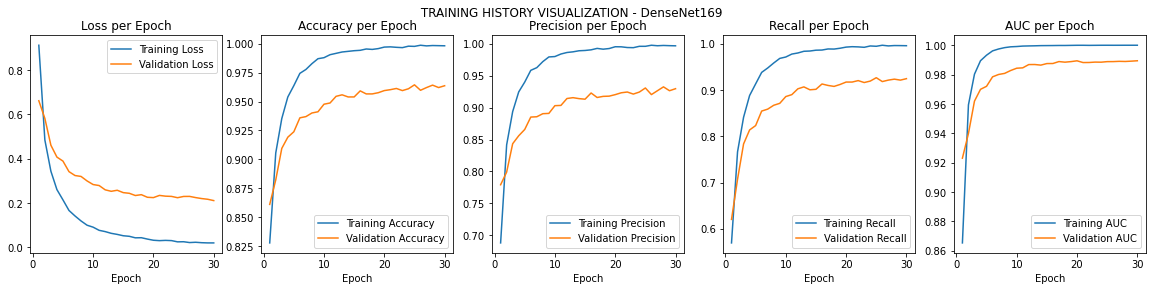

In [ ]:
plot_history(dense_model_history, 'DenseNet169')

### Hasil

Hasil trainingnya dievaluasi menggunakan data "train", "val", dan "test". Kemudian, dibuat pula matriks confusion nya yang juga disimpan di Google Drive. 

In [ ]:
dense_scores = evaluation(dense_model, train_data, train_labels, val_data, val_labels, test_data, test_labels)

Train Scores:
280/280 [==============================] - 22s 59ms/step - loss: 4.3009e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Validation Scores:
30/30 [==============================] - 2s 80ms/step - loss: 0.2114 - accuracy: 0.9637 - precision: 0.9295 - recall: 0.9247 - auc: 0.9894
Test Scores:
31/31 [==============================] - 2s 76ms/step - loss: 0.1651 - accuracy: 0.9716 - precision: 0.9459 - recall: 0.9400 - auc: 0.9947


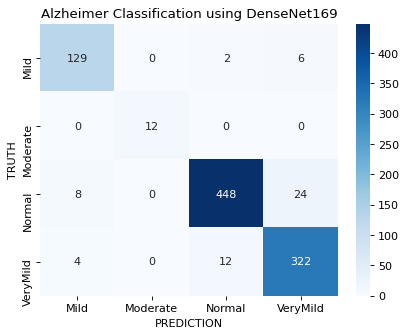

In [ ]:
plot_matrix(dense_model, test_data, test_labels, 'DenseNet169')

## Model ResNet50
### Pendefinisian Model
Model yang asli diimport dari tensorflow. Kemudian model itu dimodifikasi untuk meningkatkan performanya. Modifikasi di sini berdasarkan referensi dan berbagai percobaan yang telah dilakukan. Kemudian, model tersebut dicompile dengan optimizer tertentu. 

In [6]:
# Base Model
# "include_top" ditiadakan karena bagian klasifikasinya tidak \dibutuhkan dan akan kita tambah sendiri
# "weights" diatur agar modelnya memuat pretrained weights untuk ekstraksi fitur dari citra
base_model = ResNet50(input_shape=(dim[0],dim[1],3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 1s 0us/step


In [7]:
# Menjaga agar pretrained layer nya tidak berubah saat training
for layer in base_model.layers:
    layer.trainable=False

# Penyusunan model dan penambahan layer-layer
res_model=Sequential()
res_model.add(base_model)
res_model.add(Flatten())
res_model.add(BatchNormalization())
res_model.add(Dense(1024,activation='relu', kernel_initializer='he_uniform'))
res_model.add(BatchNormalization())
res_model.add(Activation('relu'))
res_model.add(Dropout(0.25))
res_model.add(Dense(1024,activation='relu', kernel_initializer='he_uniform'))
res_model.add(BatchNormalization())
res_model.add(Activation('relu'))
res_model.add(Dropout(0.25))
res_model.add(Dense(4,activation='softmax')) # layer terakhir yang menjadi output terakhir

res_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 6, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 86016)             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 86016)             344064    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              88081408  
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_4 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

In [ ]:
# Compiling dengan Optimizer
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True, name='SGD') 
res_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=Metrics)

### Training

Dilakukan menggunakan data dan parameter yang telah didefinisikan sebelumnya. Terdapat pula plot parameter ukur terhadap epochs untuk menggambarkan perkembangannya. Data, plot, dan model yang dihasilkan disimpan di Google Drive.

In [ ]:
res_model_history = res_model.fit(
    train_data,train_labels,validation_data=(val_data,val_labels),
    epochs=eps,batch_size=batch, shuffle=True)

Epoch 1/30
448/448 [==============================] - 28s 53ms/step - loss: 1.3272 - accuracy: 0.8209 - precision: 0.6758 - recall: 0.5391 - auc: 0.8421 - val_loss: 0.9697 - val_accuracy: 0.8026 - val_precision: 0.7469 - val_recall: 0.3180 - val_auc: 0.8414
Epoch 2/30
448/448 [==============================] - 22s 49ms/step - loss: 0.8361 - accuracy: 0.8354 - precision: 0.7082 - recall: 0.5811 - auc: 0.8813 - val_loss: 0.7738 - val_accuracy: 0.8428 - val_precision: 0.7525 - val_recall: 0.5533 - val_auc: 0.8946
Epoch 3/30
448/448 [==============================] - 22s 49ms/step - loss: 0.7161 - accuracy: 0.8585 - precision: 0.7571 - recall: 0.6390 - auc: 0.9115 - val_loss: 0.6973 - val_accuracy: 0.8546 - val_precision: 0.7611 - val_recall: 0.6098 - val_auc: 0.9145
Epoch 4/30
448/448 [==============================] - 22s 49ms/step - loss: 0.6627 - accuracy: 0.8677 - precision: 0.7726 - recall: 0.6671 - auc: 0.9243 - val_loss: 0.6787 - val_accuracy: 0.8648 - val_precision: 0.7754 - val_r

In [ ]:
res_model.save('ResNet50_model.h5')
copy('/content/ResNet50_model.h5', '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/ResNet50_model.h5')
res_model.save_weights('ResNet50_weights.h5')
copy('/content/ResNet50_weights.h5', '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/ResNet50_weights.h5')

'/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/ResNet50_weights.h5'

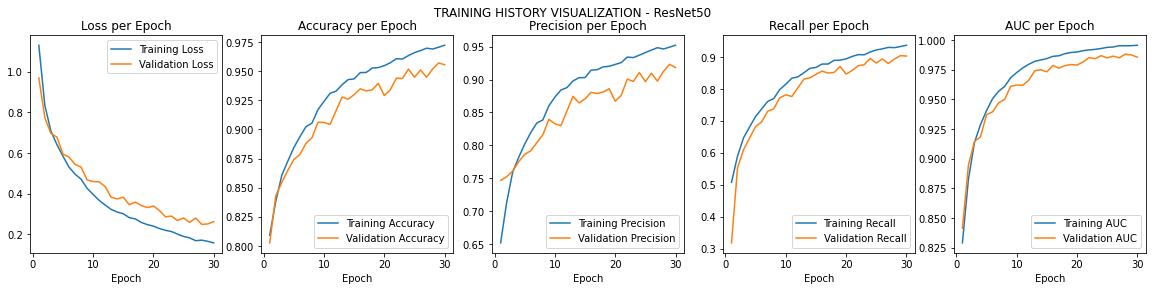

In [ ]:
plot_history(res_model_history, 'ResNet50')

### Hasil

Hasil trainingnya dievaluasi menggunakan data "train", "val", dan "test". Kemudian, dibuat pula matriks confusion nya yang juga disimpan di Google Drive. 

In [ ]:
res_scores = evaluation(res_model, train_data, train_labels, val_data, val_labels, test_data, test_labels)

Train Scores:
280/280 [==============================] - 16s 51ms/step - loss: 0.0422 - accuracy: 0.9959 - precision: 0.9931 - recall: 0.9905 - auc: 0.9999
Validation Scores:
30/30 [==============================] - 2s 56ms/step - loss: 0.2629 - accuracy: 0.9555 - precision: 0.9181 - recall: 0.9027 - auc: 0.9855
Test Scores:
31/31 [==============================] - 2s 54ms/step - loss: 0.2950 - accuracy: 0.9467 - precision: 0.8993 - recall: 0.8862 - auc: 0.9831


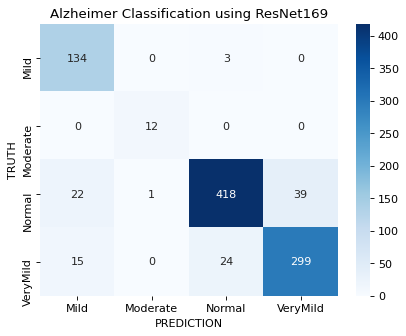

In [ ]:
plot_matrix(res_model, test_data, test_labels, 'ResNet169')

## Model VGG16
### Pendefinisian Model
Model yang asli diimport dari tensorflow. Kemudian model itu dimodifikasi untuk meningkatkan performanya. Modifikasi di sini berdasarkan referensi dan berbagai percobaan yang telah dilakukan. Kemudian, model tersebut dicompile dengan optimizer tertentu. 

In [8]:
# Base Model
# "include_top" ditiadakan karena bagian klasifikasinya tidak \dibutuhkan dan akan kita tambah sendiri
# pooling yang dilakukan adalah max-pooling
base_model = VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max')

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
# Penyusunan model dan penambahan layer-layer
vgg_model=Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(1024,activation='relu', kernel_initializer='he_uniform'))
vgg_model.add(Dropout(0.25))
vgg_model.add(Dense(4,activation='softmax')) # layer terakhir untuk output akhir

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 4100      
Total params: 15,244,100
Trainable params: 15,244,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling dengan Optimizer
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True, name='SGD') 
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=Metrics)

### Training

Dilakukan menggunakan data dan parameter yang telah didefinisikan sebelumnya. Terdapat pula plot parameter ukur terhadap epochs untuk menggambarkan perkembangannya. Data, plot, dan model yang dihasilkan disimpan di Google Drive.

In [ ]:
vgg_model_history = vgg_model.fit(
    train_data,train_labels,validation_data=(val_data,val_labels),
    epochs=eps,batch_size=batch, shuffle=True)

Epoch 1/30
448/448 [==============================] - 61s 128ms/step - loss: 1.1436 - accuracy: 0.8282 - precision: 0.7381 - recall: 0.4810 - auc: 0.8528 - val_loss: 0.7253 - val_accuracy: 0.8342 - val_precision: 0.7313 - val_recall: 0.5324 - val_auc: 0.9016
Epoch 2/30
448/448 [==============================] - 56s 124ms/step - loss: 0.5718 - accuracy: 0.8783 - precision: 0.7939 - recall: 0.6929 - auc: 0.9412 - val_loss: 0.5996 - val_accuracy: 0.8588 - val_precision: 0.7494 - val_recall: 0.6538 - val_auc: 0.9325
Epoch 3/30
448/448 [==============================] - 56s 124ms/step - loss: 0.4001 - accuracy: 0.9182 - precision: 0.8572 - recall: 0.8074 - auc: 0.9713 - val_loss: 0.4806 - val_accuracy: 0.8949 - val_precision: 0.8064 - val_recall: 0.7626 - val_auc: 0.9575
Epoch 4/30
448/448 [==============================] - 56s 124ms/step - loss: 0.2613 - accuracy: 0.9494 - precision: 0.9093 - recall: 0.8858 - auc: 0.9877 - val_loss: 0.3569 - val_accuracy: 0.9315 - val_precision: 0.8796 - v

In [ ]:
vgg_model.save('VGG16_model.h5')
copy('/content/VGG16_model.h5', '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/VGG16_model.h5')
vgg_model.save_weights('VGG16_weights.h5')
copy('/content/VGG16_weights.h5', '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/VGG16_weights.h5')

'/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/VGG16_weights.h5'

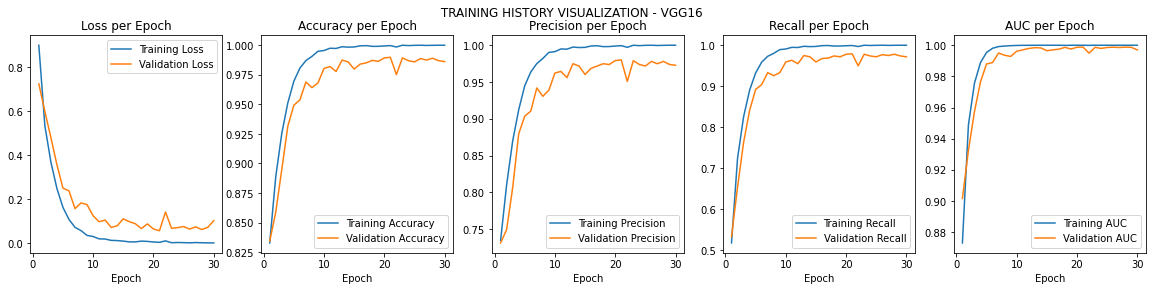

In [ ]:
plot_history(vgg_model_history, 'VGG16')

### Hasil

Hasil trainingnya dievaluasi menggunakan data "train", "val", dan "test". Kemudian, dibuat pula matriks confusion nya yang juga disimpan di Google Drive. 

In [ ]:
vgg_scores = evaluation(vgg_model, train_data, train_labels, val_data, val_labels, test_data, test_labels)

Train Scores:
280/280 [==============================] - 17s 51ms/step - loss: 2.6952e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Validation Scores:
30/30 [==============================] - 3s 118ms/step - loss: 0.1017 - accuracy: 0.9861 - precision: 0.9728 - recall: 0.9718 - auc: 0.9970
Test Scores:
31/31 [==============================] - 2s 71ms/step - loss: 0.0644 - accuracy: 0.9889 - precision: 0.9783 - recall: 0.9772 - auc: 0.9982


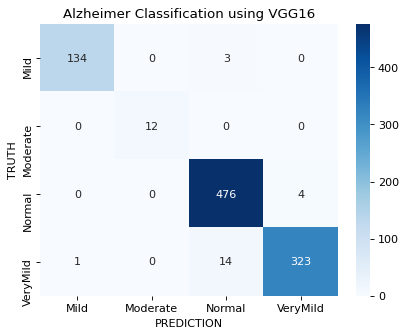

In [ ]:
plot_matrix(vgg_model, test_data, test_labels, 'VGG16')

## Perbandingan

Perbandingan performa ketiga model dilihat dari hasil evaluation nya. Hasil tersebut dibuat tabel menggunakan fungsi DataFrame pada pandas kemudian tabelnya disatukan. Tabel itu juga disimpan dalam bentuk .csv

In [ ]:
dense_df = pd.DataFrame(dense_scores) # membuat tabel 1
res_df = pd.DataFrame(res_scores) # membuat tabel 2
vgg_df = pd.DataFrame(vgg_scores) # membuat tabel 3
Final_DF = pd.concat([dense_df, res_df, vgg_df], axis=1, keys=['DenseNet169', 'ResNet50', 'VGG16']) # menggabungkan tabel
Final_DF.index = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC'] # memberikan label untuk barisnya
Final_DF.to_csv('Final_Result.csv') # menyimpan tabel dalam bentuk .csv
copy('/content/Final_Result.csv', # copy file .csv ke Google Drive
     '/content/gdrive/My Drive/Project TPC - Alzheimer MRI Classification/Final_Result.csv')
Final_DF

DenseNet169                      ...    VGG16                    
                train       val      test  ...    train       val      test
Loss          0.00043  0.211389  0.165120  ...  0.00027  0.101679  0.064413
Accuracy      1.00000  0.963651  0.971562  ...  1.00000  0.986140  0.988883
Precision     1.00000  0.929548  0.945890  ...  1.00000  0.972775  0.978261
Recall        1.00000  0.924686  0.940021  ...  1.00000  0.971757  0.977249
AUC           1.00000  0.989396  0.994723  ...  1.00000  0.996993  0.998189

[5 rows x 9 columns]

Dari tabel di atas, terlihat bahwa **dari segi akurasi dan AUC, ketiga model sudah menunjukan performa yang sangat bagus**. Untuk tiga parameter ukur lainnya, VGG16 memberikan hasil terbaik diikuti DenseNet169 kemudian ResNet50. 

Terlihat bahwa **model VGG16 memberikan performa yang paling baik** dibanding dua lainnya. Ini juga terlihat dari kurva history antara parameter ukur terhadap epoch. Kurva dari model ResNet50 berubah secara relatif lambat dibanding dua lainnya. Kurva dari model DenseNet169 bisa berubah dengan cepat namun pengujian validasinya masih tertinggal jauh dari pengujian training. **Kurva dari model VGG16 memberikan perubahan yang cepat dan tepat baik untuk pengujian training ataupun validasi**. 

Namun, VGG16 bukan tanpa kelemahan. Dibanding dua lainnya, **proses training  VGG16 membutuhkan waktu hampir tiga kali lebih lama**. Seandainya epoch untuk DenseNet169 dan ResNet50 dibuat tiga kalinya sehingga waktu proses trainingnya seperti VGG16, mungkin saja keduanya memberikan performa akhir yang tidak jauh berbeda. 

Bagaimana pun juga, **secara umum ketiga model sudah memberikan performa yang sangat baik**, meski tentu masih dapat ditingkatkan. 